# Hyperparameters with random search are used to find the tuning

## Package Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.base import BaseEstimator, RegressorMixin

## Load DATA and Merge

In [2]:
# Set random seeds to ensure reproducible results
random_search_seed = 42  # Seeds for random searches
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check whether CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read forex price data and sentiment data
forex_data = pd.read_csv('E:/zuoye/PROJECT_1/Forex_DATA/eurusd_forex_data.csv')
sentiment_data = pd.read_excel('E:/zuoye/PROJECT_1/Sentiment_NEWS/weighted_sentiments_by_day.xlsx')

# Convert the Date column to datetime and ensure both datasets use the same time zone
forex_data['Date'] = pd.to_datetime(forex_data['Date']).dt.tz_localize(None) 
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date']).dt.tz_localize(None)

# Set Date as index before merging
forex_data.set_index('Date', inplace=True)
sentiment_data.set_index('Date', inplace=True)

# Use outer join to ensure all unique dates are retained
total_dates = pd.date_range(start=min(forex_data.index.min(), sentiment_data.index.min()), 
                            end=max(forex_data.index.max(), sentiment_data.index.max()), freq='D')

# Reindex to fill in any missing dates and merge
forex_data = forex_data.reindex(total_dates).rename_axis('Date').reset_index()
sentiment_data = sentiment_data.reindex(total_dates).rename_axis('Date').reset_index()

# Merge the datasets based on date
merged_data = pd.merge(forex_data, sentiment_data, on='Date', how='outer').sort_values(by='Date').fillna(method='ffill')

# Make sure 'Date' is the index again
merged_data.set_index('Date', inplace=True)

Using device: cuda


C:\Users\THUNDEROBOT\AppData\Local\Temp\ipykernel_7752\3708461841.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = pd.merge(forex_data, sentiment_data, on='Date', how='outer').sort_values(by='Date').fillna(method='ffill')


## Sliding Window

In [3]:
# Set the size of the sliding window
window_size = 5

# Create a list of lag columns to add
lagged_columns_tech_only = []
lagged_columns_with_sentiment = []

# Create a sliding window feature that uses previous days' data to predict prices for the next 1 day
for i in range(1, window_size + 1):
    # Lag value of technical indicators
    lagged_columns_tech_only.extend([
        merged_data['Open'].shift(i).rename(f'Open_lag_{i}'),
        merged_data['High'].shift(i).rename(f'High_lag_{i}'),
        merged_data['Low'].shift(i).rename(f'Low_lag_{i}'),
        merged_data['Close'].shift(i).rename(f'Close_lag_{i}')  
    ])
    
    # Lag value of technology + emotion indicator (for technology + emotion model)
    lagged_columns_with_sentiment.extend([
        merged_data['Open'].shift(i).rename(f'Open_lag_{i}'),
        merged_data['High'].shift(i).rename(f'High_lag_{i}'),
        merged_data['Low'].shift(i).rename(f'Low_lag_{i}'),
        merged_data['Close'].shift(i).rename(f'Close_lag_{i}'), 
        merged_data['eur_positive'].shift(i).rename(f'eur_positive_lag_{i}'),
        merged_data['eur_neutral'].shift(i).rename(f'eur_neutral_lag_{i}'),
        merged_data['eur_negative'].shift(i).rename(f'eur_negative_lag_{i}'),
        merged_data['usd_positive'].shift(i).rename(f'usd_positive_lag_{i}'),
        merged_data['usd_neutral'].shift(i).rename(f'usd_neutral_lag_{i}'),
        merged_data['usd_negative'].shift(i).rename(f'usd_negative_lag_{i}')
    ])

# Create target column
merged_data['target_next_day'] = merged_data['Close'].shift(-1)

# Concatenate technology model data sets
merged_data_tech_only = pd.concat(lagged_columns_tech_only, axis=1).join(merged_data['target_next_day']).dropna()

# Splicing technology + emotion model data set
merged_data_with_sentiment = pd.concat(lagged_columns_with_sentiment, axis=1).join(merged_data['target_next_day']).dropna()

# Generate the final technical and technical + emotional data set
# Pure technical indicators data set
technical_columns = [col for col in merged_data_tech_only.columns if 'eur' not in col and 'usd' not in col]
merged_data_technical = merged_data_tech_only[technical_columns]

# Normalize the data to ensure the features are within a similar range
scaler = MinMaxScaler()
merged_data_technical[technical_columns] = scaler.fit_transform(merged_data_technical[technical_columns])
merged_data_with_sentiment.iloc[:, :-1] = scaler.fit_transform(merged_data_with_sentiment.iloc[:, :-1])

# Apply the scaler to target_next_day as well
scaler_target = MinMaxScaler()
merged_data_technical['target_next_day'] = scaler_target.fit_transform(merged_data_technical[['target_next_day']])
merged_data_with_sentiment['target_next_day'] = scaler_target.fit_transform(merged_data_with_sentiment[['target_next_day']])

# Technology + emotional data set
merged_data_all = merged_data_with_sentiment.copy()

## LSTM and Hyperparameter search

In [4]:
# Define data preparation functions, including creating sliding Windows
def prepare_data_for_cv(data):
    feature_columns = [col for col in data.columns if 'target_next_day' not in col]
    # Prepare features and objectives
    X = data[feature_columns].values
    y = data['target_next_day'].values
    dates = data.index

    # Create sliding window features and targets
    def create_sliding_windows(X, y, dates, window_size):
        X_windows, y_windows, date_windows = [], [], []
        for i in range(len(X) - window_size):
            X_windows.append(X[i:i + window_size])
            y_windows.append(y[i + window_size])
            date_windows.append(dates[i + window_size].strftime('%Y-%m-%d'))
        return np.array(X_windows), np.array(y_windows), np.array(date_windows)

    X_windows, y_windows, date_windows = create_sliding_windows(X, y, dates, window_size)

    return X_windows, y_windows, date_windows

# only technical data
X_windows_tech, y_windows_tech, dates_windows_tech = prepare_data_for_cv(merged_data_technical)

# data with technical and emotional indicators
X_windows_all, y_windows_all, dates_windows_all = prepare_data_for_cv(merged_data_all)

# Split data into training and testing sets
train_size = int(0.8 * len(X_windows_tech))
X_train, X_test = X_windows_tech[:train_size], X_windows_tech[train_size:]
y_train, y_test = y_windows_tech[:train_size], y_windows_tech[train_size:]
dates_train, dates_test = dates_windows_tech[:train_size], dates_windows_tech[train_size:]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Output a predicted close price

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
        return self.fc(lstm_out)

# Define the training function for the model
def train_model(X, y, params):
    # Create dataset and data loader
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False)

    # Define the model
    model = LSTMModel(input_size=X.shape[2], hidden_size=params['hidden_size'], 
                      num_layers=params['num_layers'], dropout=params['dropout']).to(device)

    criterion = nn.SmoothL1Loss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training loop
    model.train()
    for epoch in range(params['epochs']):
        epoch_loss = 0
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss)

    return model

# Hyperparameter search space
param_distributions = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'batch_size': [16, 32, 64, 128],
    'learning_rate': [1e-3, 5e-4, 1e-4, 1e-5],
    'epochs': [10, 20, 30, 50]
}

# Time series split
tscv = TimeSeriesSplit(n_splits=5)



class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=10, hidden_size=32, num_layers=1, dropout=0.2, batch_size=32, learning_rate=1e-3, epochs=10):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = train_model(X, y, {
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'dropout': self.dropout,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs
        })
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(torch.tensor(X, dtype=torch.float32).to(device)).cpu().numpy()
        return predictions

# Hyperparameter search with LSTMEstimator
lstm_estimator = LSTMEstimator(input_size=X_windows_tech.shape[2])
random_search = RandomizedSearchCV(estimator=lstm_estimator, param_distributions=param_distributions,
                                   random_state=random_search_seed, 
                                   n_iter=200, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=1)

## Visualize the predictions

C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please

Best parameters found: {'num_layers': 1, 'learning_rate': 0.001, 'hidden_size': 128, 'epochs': 50, 'dropout': 0.5, 'batch_size': 32}
MAE: 0.008932155724179772
MSE: 0.00011611896569971459
RMSE: 0.010775851042943874
MAPE: 0.7424020913864184%


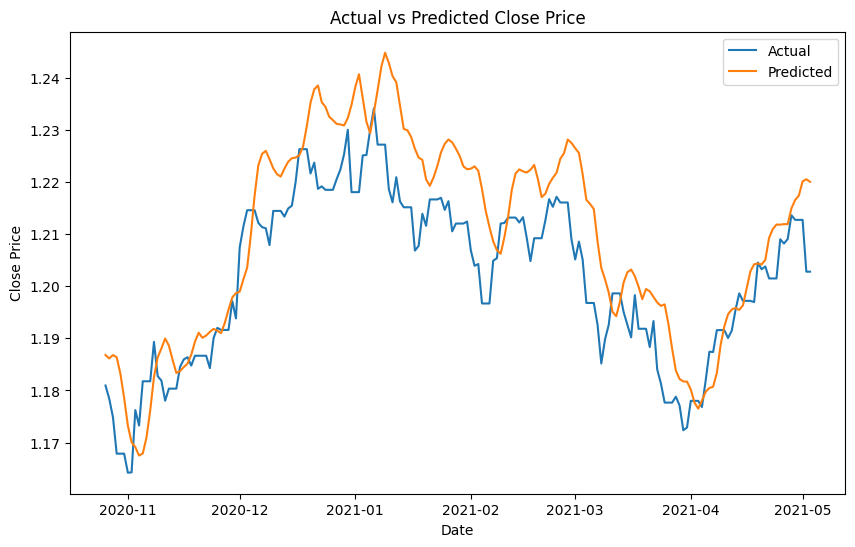

In [5]:
def evaluate_model(model, X_test, y_test, dates_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

    # De-normalize predictions and actual values
    predictions = scaler_target.inverse_transform(predictions)
    y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Calculating evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    
    # Visual prediction results
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(dates_test), y_test, label='Actual')
    plt.plot(pd.to_datetime(dates_test), predictions, label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Price')
    plt.show(block=False)
    plt.pause(0.001)

# Run a hyperparameter search
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best parameters found:", best_params)

# The final model is trained using the best parameters
final_model = train_model(X_train, y_train, best_params)

# Predict and evaluate the model on the test set
evaluate_model(final_model, X_test, y_test, dates_test)

## Using the best parameters to Predict and evaluate on the test set

C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\THUNDEROBOT\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


MAE: 0.008970264422526368
MSE: 0.00011867780410147571
RMSE: 0.0108939342802073
MAPE: 0.745713805811047%


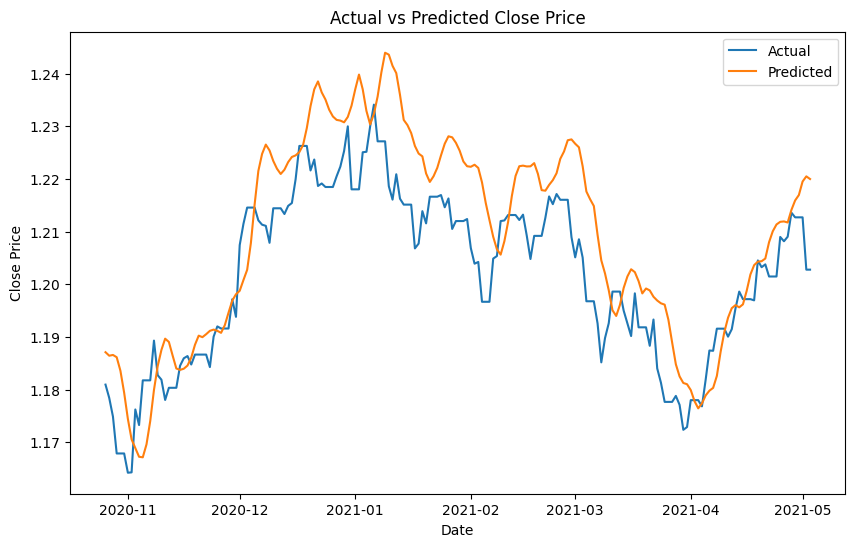

In [6]:
final_model = train_model(X_train, y_train, best_params)
evaluate_model(final_model, X_test, y_test, dates_test)